In [1]:
from qick import *
from qick.helpers import gauss

import time
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = QickSoc()
# Set the loopback DAC channel to be in 1st Nyquist zone mode
soc.set_nyquist(ch=7,nqz=1); 

soc.set_nyquist(ch=6,nqz=1); 

resetting clocks: 204.8
Not all DAC and ADC PLLs are locked. You may want to repeat the initialization of the QickSoc.


In [168]:
from tqdm import tqdm_notebook as tqdm
import numpy as np
import time
class AveragerProgram(QickProgram):
    """
    AveragerProgram class is an abstract base class for programs which do loop over experiments in hardware. It consists of a template program which takes care of the loop and acquire methods that talk to the processor to stream single shot data in real-time and then reshape and average it appropriately.

    :param cfg: Configuration dictionary
    :type cfg: dict
    """
    def __init__(self, cfg):
        """
        Constructor for the AveragerProgram, calls make program at the end so for classes that inherit from this if you want it to do something before the program is made and compiled either do it before calling this __init__ or put it in the initialize method.
        """
        QickProgram.__init__(self)
        self.cfg=cfg
        self.make_program()
    
    def initialize(self):
        """
        Abstract method for initializing the program and can include any instructions that are executed once at the beginning of the program.
        """
        pass
    
    def body(self):
        """
        Abstract method for the body of the program
        """
        pass
    
    def make_program(self):
        """
        A template program which repeats the instructions defined in the body() method the number of times specified in self.cfg["reps"].
        """
        p=self
        
        rjj=14
        rcount=15
        p.initialize()
        p.regwi (0, rcount,0)
        p.regwi (0, rjj, self.cfg["reps"]-1)
        p.label("LOOP_J")

        p.body()

        p.mathi(0,rcount,rcount,"+",1)
        
        p.memwi(0,rcount,1)
                
        p.loopnz(0, rjj, 'LOOP_J')
       
        p.end()        

    def reading_voltage(self, soc, read_length, progress=True, debug=False):
        if "reps" not in self.cfg or self.cfg["reps"] != 1:
            print ("Warning reps is not set to 1, and this acquire method expects reps=1")
            
        for ii, freq in enumerate(self.cfg["adc_freqs"]):
            soc.configure_readout(ii,output="product", frequency=freq)

        d_avg0 = np.zeros((2, read_length))
        soft_avgs=self.cfg["soft_avgs"]        
        tproc=soc.tproc
        tproc.load_bin_program(self.compile(debug=debug))
        #for each soft average stop the processor, run and average decimated data
        #for ii in tqdm(range(soft_avgs),disable=not progress):
        tproc.stop()
        # Configure and enable buffer capture.
        for ii, jj in enumerate([read_length, read_length]):
            soc.config_avg(ii,address=0,length=jj, enable=True)
            soc.config_buf(ii, address=0, length=jj, enable=True)

        tproc.single_write(addr= 1,data=0)   #make sure count variable is reset to 0       
        tproc.start() #runs the assembly program

        #count=0
        #while count<1:
            #count = tproc.single_read(addr= 1)

        d0 = soc.get_decimated(ch=0, address=0, length=read_length)

        d_avg0+=d0

        return d0
        
        
    def acquire_decimated_1(self, soc, load_pulses=True, progress=True, debug=False):
        #set reps to 1 since we are going to use soft averages
        if "reps" not in self.cfg or self.cfg["reps"] != 1:
            print ("Warning reps is not set to 1, and this acquire method expects reps=1")
        

        #Configure the readout down converters
        for ii, freq in enumerate(self.cfg["adc_freqs"]):
            soc.configure_readout(ii,output="product", frequency=freq)
        
        if load_pulses: 
            self.load_pulses(soc)

        soft_avgs=self.cfg["soft_avgs"]        

        d_avg0=np.zeros((2,self.cfg["adc_lengths"][0]))
        d_avg1=np.zeros((2,self.cfg["adc_lengths"][1]))
        
        # load the program - it's always the same, so this only needs to be done once
        tproc=soc.tproc
        tproc.load_bin_program(self.compile(debug=debug))
        #for each soft average stop the processor, run and average decimated data
        for ii in tqdm(range(soft_avgs),disable=not progress):
            tproc.stop()
            # Configure and enable buffer capture.
            for ii, length in enumerate(self.cfg["adc_lengths"]):
                soc.config_avg(ii,address=0,length=length, enable=True)
                soc.config_buf(ii, address=0, length=length, enable=True)

            tproc.single_write(addr= 1,data=0)   #make sure count variable is reset to 0       
            tproc.start() #runs the assembly program

            count=0
            while count<1:
                count = tproc.single_read(addr= 1)
                
            d0 = soc.get_decimated(ch=0, address=0, length=self.cfg["adc_lengths"][0])
            d1 = soc.get_decimated(ch=1, address=0, length=self.cfg["adc_lengths"][1])
            
            d_avg0+=d0
            d_avg1+=d1
            
        return d_avg0/soft_avgs,d_avg1/soft_avgs
    
    def send_pulse_now(self, soc, load_pulses=True, progress=True, debug=False):
        #set reps to 1 since we are going to use soft averages
        if "reps" not in self.cfg or self.cfg["reps"] != 1:
            print ("Warning reps is not set to 1, and this acquire method expects reps=1")
            
        #for ii, freq in enumerate(self.cfg["adc_freqs"]):
            #soc.configure_readout(ii,output="product", frequency=freq)
        if load_pulses: 
            self.load_pulses(soc)
        
        # load the program - it's always the same, so this only needs to be done once
        tproc=soc.tproc
        tproc.load_bin_program(self.compile(debug=debug))
        tproc.stop()

        tproc.start() #runs the assembly program

In [169]:
class reading_program(AveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)

    def initialize(self):
        cfg=self.cfg   
        r_freq=self.sreg(cfg["res_ch"], "freq")   #Get frequency register for res_ch
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2          #add length of adc acquisition to config
        self.cfg["adc_freqs"]=[self.cfg["pulse_freq"]]*2   #add frequency of adc ddc to config

    
    def body(self):
        self.synci(200) # give processor time to get ahead of the pulses
        self.trigger_adc(adc1=1, adc2=1,adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        # control should wait until the readout is over
        self.waiti(0, self.cfg["adc_trig_offset"]+self.cfg["readout_length"]) 
        self.sync_all(soc.us2cycles(self.cfg["relax_delay"]))  # sync all channels

In [170]:
class pulse_send_on_trigger(AveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)

    def initialize(self):
        cfg=self.cfg   
        r_freq=self.sreg(cfg["res_ch"], "freq")   #Get frequency register for res_ch
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2          #add length of adc acquisition to config
        self.cfg["adc_freqs"]=[self.cfg["pulse_freq"]]*2   #add frequency of adc ddc to config
        self.regwi(0,1,self.cfg["threshold"])

        # Set value of number 
        self.regwi(0,2,self.cfg["number"])
        self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["length"])  #add a constant pulse to the pulse library
        self.add_pulse(ch=self.cfg["res_ch_2"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["length"])  #add a constant pulse to the pulse library

        freq=soc.freq2reg(cfg["pulse_freq"])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.pulse(ch=cfg["res_ch"], name="measure", freq=freq, phase=0, gain=cfg["pulse_gain"], t= 0, play=False)
        self.pulse(ch=cfg["res_ch_2"], name="measure", freq=freq, phase=0, gain=cfg["pulse_gain"], t= 0, play=False)
        
    def body(self):
        
        self.synci(200) # give processor time to get ahead of the pulses
        self.trigger_adc(adc1=1, adc2=1,adc_trig_offset=self.cfg["adc_trig_offset"])  
        self.condj(0,2,'<',1,'LABEL') 
        self.pulse(ch=self.cfg["res_ch"], length=self.cfg["length"], play=True) # play readout pulse
        self.pulse(ch=self.cfg["res_ch_2"], length=self.cfg["length"], play=True) # play readout pulse

        self.label('LABEL')
        # trigger the adc acquisition
        # control should wait until the readout is over
        self.waiti(0, self.cfg["adc_trig_offset"]+self.cfg["readout_length"]) 
        self.sync_all(soc.us2cycles(self.cfg["relax_delay"]))  # sync all channels

In [171]:
class LoopbackProgram(AveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)

    def initialize(self):
        cfg=self.cfg   
        r_freq=self.sreg(cfg["res_ch"], "freq")   #Get frequency register for res_ch
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2          #add length of adc acquisition to config
        self.cfg["adc_freqs"]=[self.cfg["pulse_freq"]]*2   #add frequency of adc ddc to config
        
        if self.cfg["pulse_style"] == "const":
            self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["length"])  #add a constant pulse to the pulse library
            self.add_pulse(ch=self.cfg["res_ch_2"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["length"])  #add a constant pulse to the pulse library
        if self.cfg["pulse_style"] == "flat_top":
            self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["length"], idata = self.cfg["idata"]) 
            self.add_pulse(ch=self.cfg["res_ch_2"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["length"], idata = self.cfg["idata"]) 
        if self.cfg["pulse_style"] == "arb":
            self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], idata = self.cfg["idata"]) 
            self.add_pulse(ch=self.cfg["res_ch_2"], name="measure", style=self.cfg["pulse_style"], idata = self.cfg["idata"]) 
        
        freq=soc.freq2reg(cfg["pulse_freq"])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.pulse(ch=cfg["res_ch_2"], name="measure", freq=freq, phase=deg2reg(-90), gain=cfg["pulse_gain"], t= 0, play=False) # pre-configure readout pulse
        self.pulse(ch=cfg["res_ch"], name="measure", freq=freq, phase=deg2reg(-90), gain=cfg["pulse_gain"], t= 0, play=False) # pre-configure readout pulse

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.synci(200) # give processor time to get ahead of the pulses
        self.trigger_adc(adc1=1, adc2=1,adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        if self.cfg["pulse_style"] == "const":
            self.pulse(ch=self.cfg["res_ch"], length=self.cfg["length"], play=True) # play readout pulse
            self.pulse(ch=self.cfg["res_ch_2"], length=self.cfg["length"], play=True) # play readout pulse
            
        if self.cfg["pulse_style"] == "flat_top":
            self.pulse(ch=self.cfg["res_ch"], name="measure", play=True) # play readout pulse
        if self.cfg["pulse_style"] == "arb":
            self.pulse(ch=self.cfg["res_ch"], play=True) # play readout pulse
        # control should wait until the readout is over
        self.waiti(0, self.cfg["adc_trig_offset"]+self.cfg["readout_length"]) 
        self.sync_all(soc.us2cycles(self.cfg["relax_delay"]))  # sync all channels


In [172]:
class conditional_LoopbackProgram(AveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)

    def initialize(self):
        cfg=self.cfg   
        r_freq=self.sreg(cfg["res_ch"], "freq")   #Get frequency register for res_ch
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2          #add length of adc acquisition to config
        self.cfg["adc_freqs"]=[self.cfg["pulse_freq"]]*2   #add frequency of adc ddc to config
        
        # Set threshold
        self.regwi(0,1,self.cfg["threshold"])

        # Set value of number 
        self.regwi(0,2,self.cfg["number"])
        self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["length"])  #add a constant pulse to the pulse library

        self.add_pulse(ch=self.cfg["res_ch_2"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["length"])  #add a constant pulse to the pulse library
        
        freq=soc.freq2reg(cfg["pulse_freq"])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.pulse(ch=cfg["res_ch"], name="measure", freq=freq, phase=0, gain=cfg["pulse_gain"], t= 0, play=False) # pre-configure readout pulse
        self.pulse(ch=cfg["res_ch_2"], name="measure", freq=freq, phase=0, gain=cfg["pulse_gain"], t= 0, play=False) # pre-configure readout pulse
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.synci(200) # give processor time to get ahead of the outputs
        self.trigger_adc(adc1=1, adc2=1,adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        
        # Apply conditional logic statement: When number is smaller than threshold, skip over playing the pulse.
        self.condj(0,2,'<',1,'LABEL') 
        self.pulse(ch=self.cfg["res_ch"], length=self.cfg["length"], play=True) # play readout pulse
        self.pulse(ch=self.cfg["res_ch_2"], length=self.cfg["length"], play=True) # play readout pulse
        self.label('LABEL')

        # control should wait until the readout is over
        self.waiti(0, self.cfg["adc_trig_offset"]+self.cfg["readout_length"]) 

        self.sync_all(soc.us2cycles(self.cfg["relax_delay"]))  # sync all channels

In [173]:
config={"res_ch":7, # --Fixed
        "res_ch_2":6, 
        "reps":1, # --Fixed
        "relax_delay":1, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "const", # --Fixed
        
        "length":100, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 150, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100,
        # Try varying soft_avgs from 1 to 200 averages 
        #"readout_freq": 0.5*100*1000,
        "number": 100,
        "threshold": 50
       }

###################
# Try it yourself !
###################





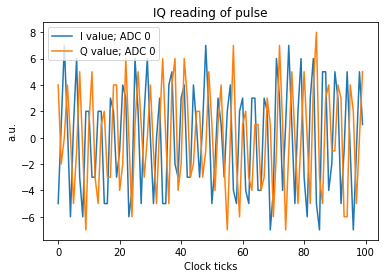

In [174]:
prog = reading_program(config)

iq0 = prog.reading_voltage(soc, 100, progress=True, debug=False)
plt.figure(1)
plt.plot(iq0[0], label="I value; ADC 0")
plt.plot(iq0[1], label="Q value; ADC 0")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("IQ reading of pulse")
plt.legend()
plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)


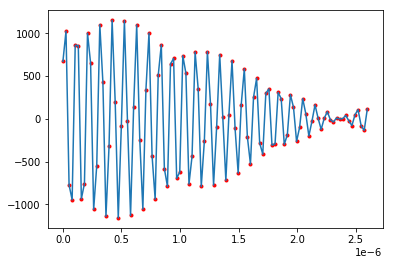

In [14]:
readout_length = config["readout_length"]
time_list = np.linspace(0, readout_length*2.6*(10**(-9)), len(iq0[0]))
voltage_list = []
start = 0
for i in range(start, len(iq0[0])):
    voltage_list.append(iq0[0][i]*np.cos(2*np.pi*(10**5)*time_list[i]) +iq0[1][i]*np.sin(2*np.pi*(10**5)*time_list[i]))  



plt.plot(time_list[start:], voltage_list, 'r.')
plt.plot(time_list[start:], voltage_list)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))


In [175]:
'''
this code reads a trigger and then sends 
'''

reading_config={"res_ch":7, # --Fixed

        "relax_delay":1, # --Fixed

        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 150, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks
       }

prog = reading_program(config)

iq0 = prog.reading_voltage(soc, 150, progress=True, debug=False)

iq0_max = max(iq0[0])
config={"res_ch":7, # --Fixed
        "res_ch_2":6, 
        "reps":1, # --Fixed
        "relax_delay":1, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "const", # --Fixed
        
        "length":100, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":1000, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 150, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100,
        # Try varying soft_avgs from 1 to 200 averages 
        #"readout_freq": 0.5*100*1000,
        "number": int(iq0_max),
        "threshold": 60
       }
print(max(iq0[0]))

prog = pulse_send_on_trigger(config)
prog.send_pulse_now(soc, load_pulses=True, progress=True, debug=False)


6000.0
